In [67]:
#pip install vaderSentiment


In [68]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Lenovo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [69]:
# # Load the dataset
df = pd.read_csv(r"C:\Users\Lenovo\Documents\Practice Files\Sentiment Analysis on Social Media Posts\LGBT_Tweets_processed.csv")



In [70]:
# Show structure
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32456 entries, 0 to 32455
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      32456 non-null  int64 
 1   date            32456 non-null  object
 2   time            32456 non-null  object
 3   id              32456 non-null  int64 
 4   tweet           32456 non-null  object
 5   language        32456 non-null  object
 6   replies_count   32456 non-null  int64 
 7   retweets_count  32456 non-null  int64 
 8   likes_count     32456 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 2.2+ MB


,Unnamed: 0,date,time,id,tweet,language,replies_count,retweets_count,likes_count
0,0,2022-08-26,10:31:10,1562991009180827649,Praying for my lgbt Nigerians 🙏🏽🙏🏽🙏🏽,en,0,0,0
1,1,2022-08-26,10:31:02,1562990976939229184,@yanmisamm So pass agg omg you really are lgbt,en,0,0,0
2,3,2022-08-26,10:30:59,1562990965442326528,@ChampionExcel @watokohom @MrAndyNgo @football...,en,0,0,0
3,7,2022-08-26,10:30:34,1562990860928659457,To be clear it doesn't justify what the LGBT c...,en,0,0,0
4,10,2022-08-26,10:30:24,1562990819485032449,good night lgbt community https://t.co/0PAMOU...,en,1,0,2


**Data Cleaning & Preprocessing**

In [72]:
# Drop missing/null values
df.dropna(subset=['tweet'], inplace=True)

In [73]:
# Filter English tweets only
df = df[df['language'] == 'en']

In [74]:
# Remove duplicates
df.drop_duplicates(subset='tweet', inplace=True)


In [75]:
# Convert 'date' to datetime format
df['date'] = pd.to_datetime(df['date'])

In [76]:
# Reset index
df.reset_index(drop=True, inplace=True)

**Sentiment Labeling with VADER**

In [78]:
# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

In [79]:
# Function to convert score to label
def get_sentiment(text):
    score = analyzer.polarity_scores(text)['compound']
    if score > 0.05:
        return 'positive'
    elif score < -0.05:
        return 'negative'
    else:
        return 'neutral'

In [80]:
# Apply to dataset
df['sentiment'] = df['tweet'].apply(get_sentiment)

**Sentiment Distribution Visualization**

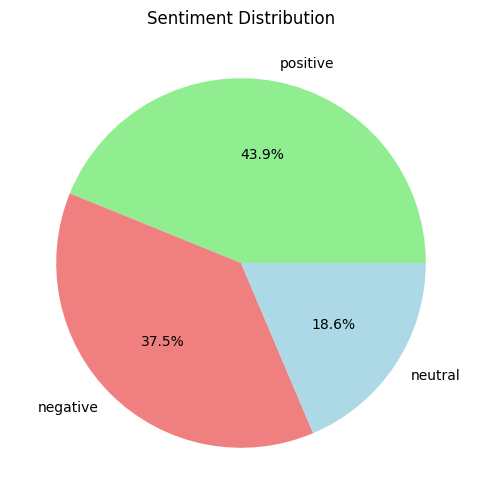

In [82]:
# Pie chart of sentiment distribution
plt.figure(figsize=(6,6))
df['sentiment'].value_counts().plot.pie(autopct='%1.1f%%', colors=['lightgreen', 'lightcoral', 'lightblue'])
plt.title("Sentiment Distribution")
plt.ylabel("")
plt.show()


**Sentiment Trend Over Time**

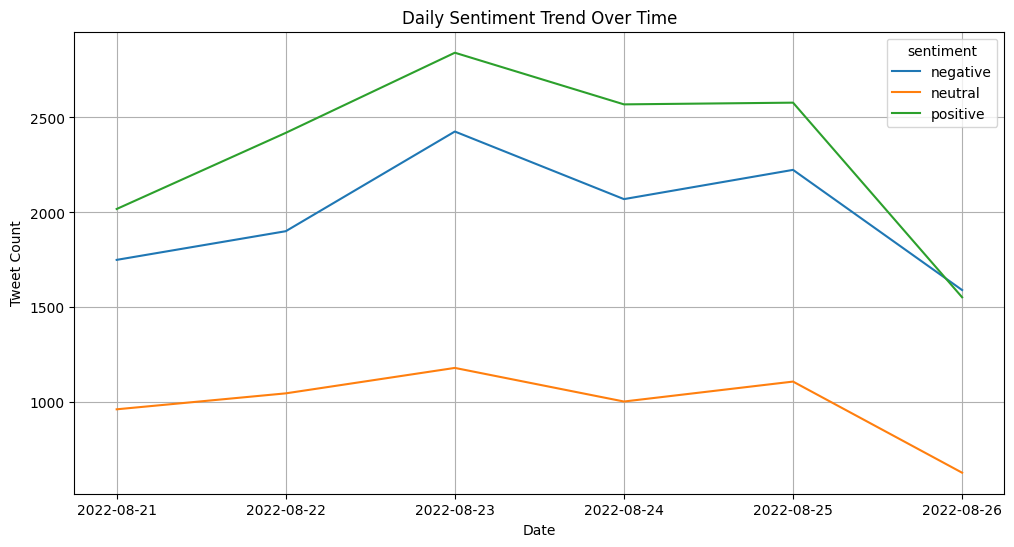

In [84]:
# Group by date and sentiment
daily_sentiment = df.groupby([df['date'].dt.date, 'sentiment']).size().unstack().fillna(0)

# Line plot
plt.figure(figsize=(12,6))
daily_sentiment.plot(ax=plt.gca())
plt.title("Daily Sentiment Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Tweet Count")
plt.grid(True)
plt.show()


**Engagement vs Sentiment**

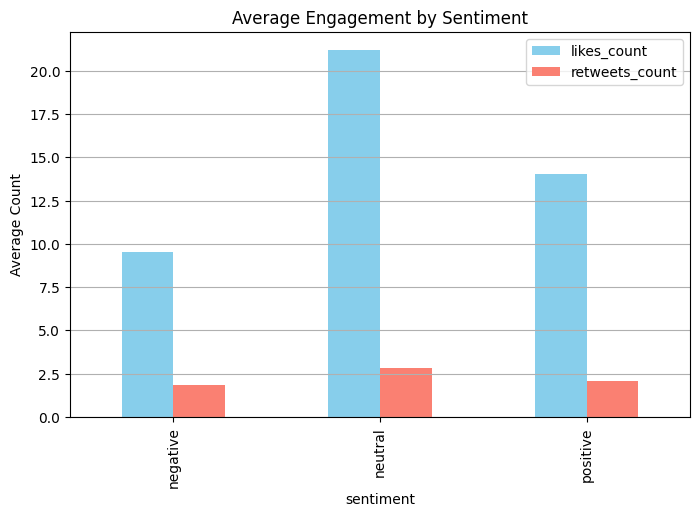

In [86]:
# Average likes and retweets by sentiment
engagement_df = df.groupby('sentiment')[['likes_count', 'retweets_count']].mean()

# Barplot
engagement_df.plot(kind='bar', figsize=(8,5), color=['skyblue', 'salmon'])
plt.title("Average Engagement by Sentiment")
plt.ylabel("Average Count")
plt.grid(axis='y')
plt.show()


**WordCloud by Sentiment**

In [88]:
# Clean text helper
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"[^A-Za-z\s]", '', text)
    return text.lower()

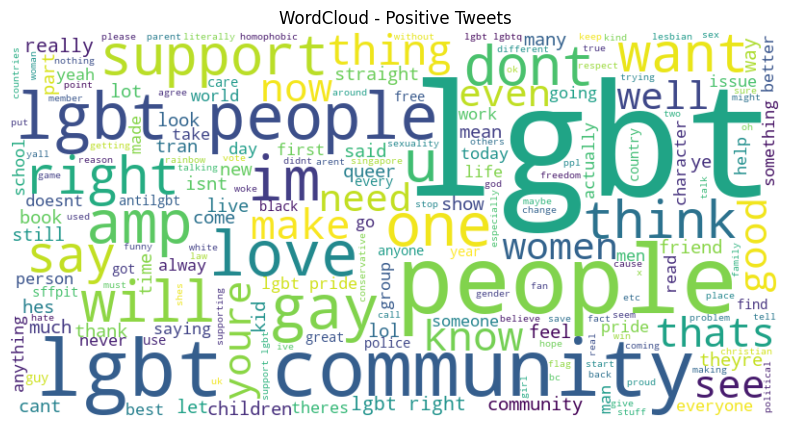

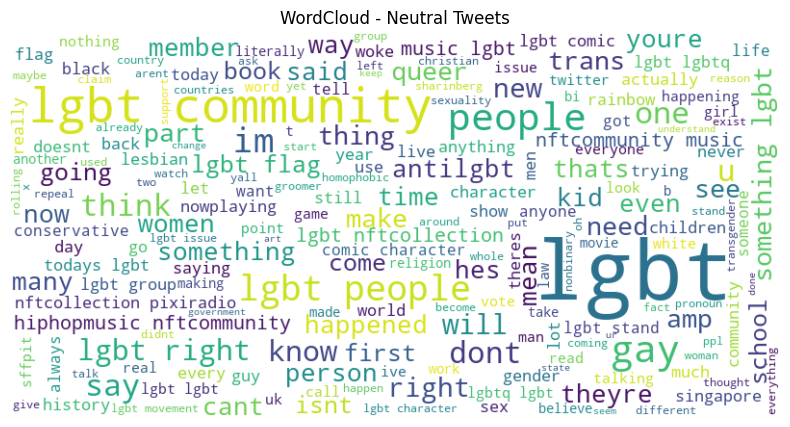

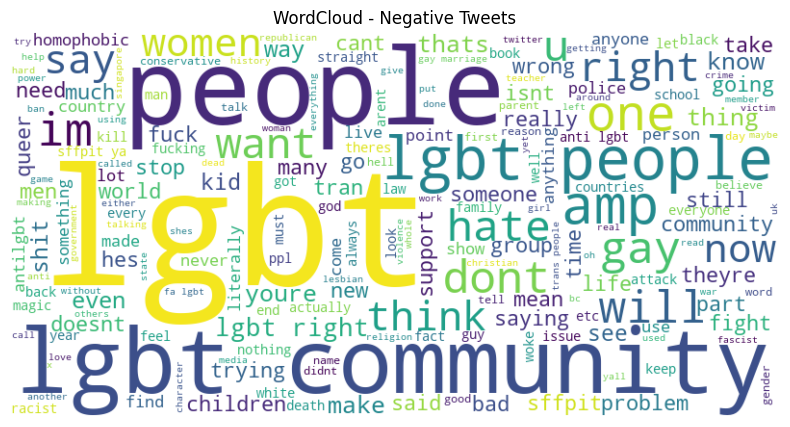

In [89]:
# Generate wordcloud for each sentiment
for label in ['positive', 'neutral', 'negative']:
    text = ' '.join(df[df['sentiment'] == label]['tweet'].apply(clean_text))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud - {label.capitalize()} Tweets")
    plt.show()

**NLP Preprocessing**

In [91]:
#import nltk
#nltk.download('punkt')  # Download sentence tokenizer
#nltk.download('stopwords')  # If using stop words
#nltk.download('wordnet')  # If using lemmatization


In [92]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # Remove links
    text = re.sub(r"[^A-Za-z\s]", '', text)  # Remove non-alphabetic
    tokens = nltk.word_tokenize(text.lower())  # Tokenize and lowercase
    filtered = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(filtered)

# Apply to all tweets
df['cleaned_tweet'] = df['tweet'].apply(preprocess_text)


In [93]:
#import nltk
#nltk.download('punkt_tab')

**Convert Text to TF-IDF Features**

In [95]:
# Vectorize text
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['cleaned_tweet'])

# Labels
y = df['sentiment']


**Train-Test Split + Model Training**

In [97]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)


LogisticRegression(max_iter=200)

**Model Evaluation**

In [99]:
# Predict
y_pred = model.predict(X_test)

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.7843137254901961

Classification Report:
               precision    recall  f1-score   support

    negative       0.78      0.78      0.78      2361
     neutral       0.78      0.65      0.71      1196
    positive       0.79      0.84      0.82      2818

    accuracy                           0.78      6375
   macro avg       0.78      0.76      0.77      6375
weighted avg       0.78      0.78      0.78      6375


Confusion Matrix:
 [[1847   96  418]
 [ 207  782  207]
 [ 327  120 2371]]


**Predict on Custom Tweet**

In [101]:
def predict_sentiment(tweet):
    cleaned = preprocess_text(tweet)
    vector = vectorizer.transform([cleaned])
    return model.predict(vector)[0]

# Example
predict_sentiment("I love how supportive people are during Pride month!")


'positive'